# TF-IDF score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of text frequency, inverse document frequency (TF-IDF) scores for human and synthetic text and use them to generate a function that takes a TF-IDF score and converts it into a Kullback-Leibler divergence (KLD) score. See the figure below from the [Wikipedia article on KLD](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

Workflow is as follows:

**Part I**
1. Calculate TF-IDF score for each text fragment.

**Part II**: parallelized over the length bins.

2. Get kernel density estimate of TF-IDF score distributions for human and synthetic text fragments in the training data.
3. Calculated the KLD between the human and synthetic TF-IDF score distributions.
4. Get a get kernel density estimate of the KLD and save it to disk.

**Park III**: Parallelized over evaluation points in each bin, bins processed serially.

5. Use the probability density function from the KLD kernel density estimate to calculate a KLD score for each text fragment in the training and testing data.
6. Add the KLD score as a new feature.

The above will be done individually for each fragment length bin and the combined data. This way the KLD score feature in each bin will capture the TF-IDF score distribution for text fragments in that specific length regime, rather that for the whole dataset.

In [1]:
from IPython.display import Image
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

## 1. Run set-up

In [2]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
import configuration as config
import functions.tf_idf_score as tf_idf_funcs
import functions.kullback_leibler_divergence as kld_funcs

Working directory: /mnt/arkk/llm_detector/classifier


In [3]:
# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Feature name
input_feature_name = 'TF-IDF score'

## 2. TF-IDF score
Before calculating a Kullback-Leibler divergence score for the TF-IDF score, we need to calculate the TF-IDF score itself for each fragment.

The TF-IDF score created for this project involves scoring each text fragment with term TF-IDF derived from the human and synthetic text fragments in the training data. The TF-IDF score is a product normalized difference calculated as:

$$ (human - synthetic)(human + synthetic) $$

Where human and synthetic refer to average TF-IDF by term for a given text fragment where the term TF-IDF values were derived from the human or synthetic text in the training dataset.

Let's parallelize the calculation over the text fragment length bins and add the features to the data in our hdf5 dataset.

In [4]:
%%time

# Calculate TF-IDF scores for all of the fragments
tf_idf_funcs.tf_idf_score(
    hdf5_file = input_file,
    score_sample = False,
    logfile_name = 'TF-IDF_score.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_score.log
CPU times: user 1.03 s, sys: 436 ms, total: 1.47 s
Wall time: 14.4 s


## 3. TF-IDF Kullback-Leibler divergence kernel density estimates

In [5]:
%%time

# Run part I of the workflow in parallel over the bins - gets kernel density estimate
# of Kullback-Leibler divergence between the feature's distribution for human and
# synthetic text fragments in the training data, saves to disk for later use.

kld_funcs.get_kullback_leibler_kdes(
    feature_name = input_feature_name,
    hdf5_file = input_file,
    logfile_name = 'TF-IDF_KLD_KDE.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_KLD_KDE.log

bin_001_050 finished: True
bin_026_075 finished: True
bin_051_100 finished: True
bin_076_125 finished: True
bin_101_150 finished: True
bin_126_175 finished: True
bin_151_200 finished: True
bin_176_225 finished: True
bin_201_250 finished: True
bin_226_275 finished: True
bin_251_300 finished: True
combined finished: True
CPU times: user 503 ms, sys: 469 ms, total: 972 ms
Wall time: 1.49 s


## 4. Evaluate TF-IDF scores and add feature

In [6]:
%%time

# Run part II of the workflow described above - uses previously stored
# kernel density estimates of the Kullback-Leibler divergence between
# the TF-IDF scores for human and synthetic text fragments
# in each bin. Loads the data from each bin sequentially and evaluates
# each text fragment's TF-IDF score. Parallelizes evaluation
# over data in the bin. Adds result back to hdf5 as new feature column.

kld_funcs.make_kullback_leibler_feature(
    feature_name = input_feature_name,
    hdf5_file = input_file,
    logfile_name = 'TF-IDF_KLD_feature_addition.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/TF-IDF_KLD_feature_addition.log

bin_001_050 finished: True
bin_026_075 finished: True
bin_051_100 finished: True
bin_076_125 finished: True
bin_101_150 finished: True
bin_126_175 finished: True
bin_151_200 finished: True
bin_176_225 finished: True
bin_201_250 finished: True
bin_226_275 finished: True
bin_251_300 finished: True
combined finished: True
CPU times: user 2.66 s, sys: 4.44 s, total: 7.1 s
Wall time: 25.4 s


## 5. Sanity check results

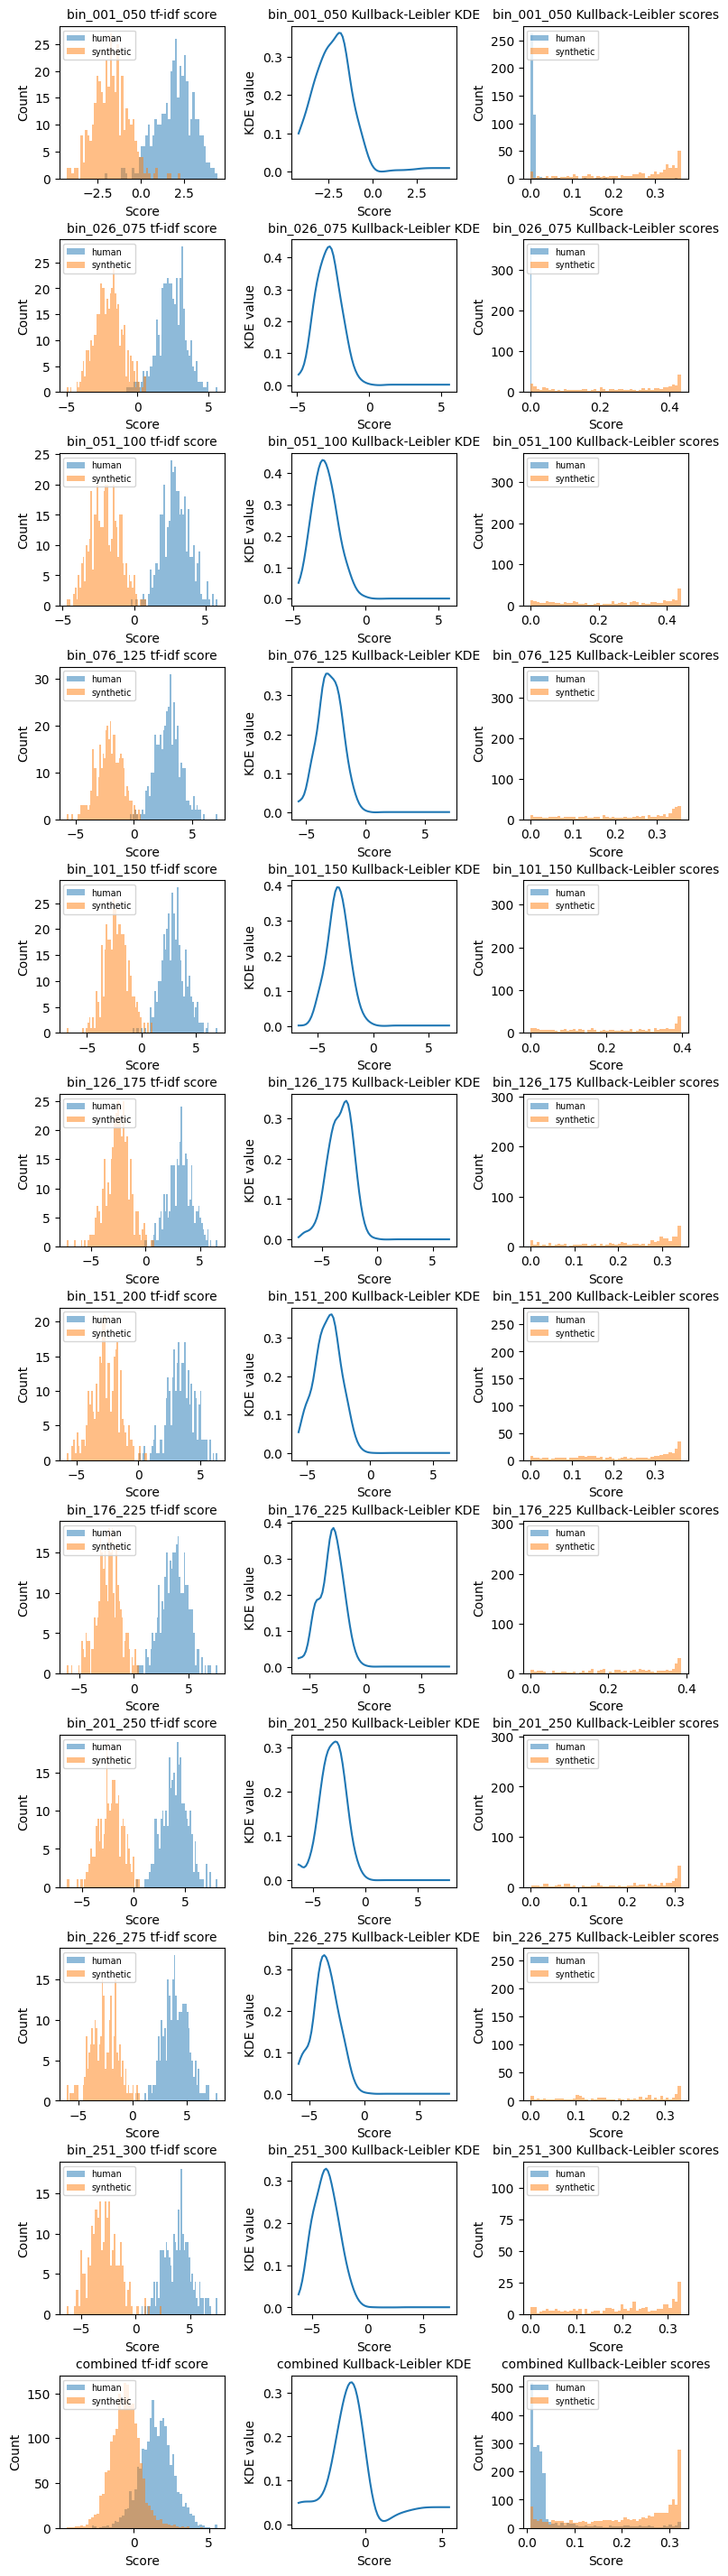

In [7]:
kld_funcs.plot_results(
    hdf5_file = input_file, 
    feature_name = input_feature_name
).show()